# DeepCube Use Case 2: 

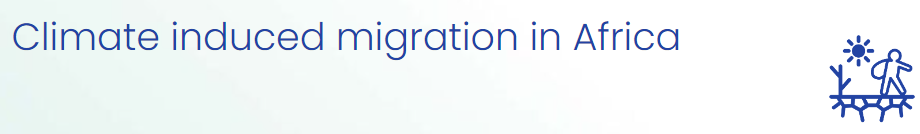


# Introduction

Use Case 2 Climate induced migration in Africa focuses on how current changing climate conditions and extremes such as heatwaves, droughts and floods influence the biosphere and the anthroposphere. 

Migration, displacement and human mobility are part of the agenda of the United Nations Framework Convention on Climate Change (UNFCCC).  Population displacement due to extreme weather events is a pressing issue demanding concerted action. Each year, an average of 22 million people are forced to flee their homes due to hazards such as floods, storms, and droughts leading to extreme vulnerability and humanitarian emergencies. In a rapidly changing climate, more frequent and severe weather extremes are expected to exacerbate human displacement. Nonetheless, there is notable debate about how much weather-related events and non-climate factors independently contribute to dislocation and migration. While sudden-onset disasters causal relations are clearly understood (e.g. floods), slow-onset disaster dynamics, such as droughts, are the most challenging side of understanding disaster-induced displacement. 

Use Case 2 aims to disentagle causal relationships by using causal discovery algorithms directly from data, without prior assumption biases.

UC2 focuses particularly on drought-induced displacement in Somalia. Due to the severe impacts of droughts in recent years (a huge concern in East-Africa) the population is being forcibly displaced and affected by recurrent food and water shortages, political inestability and violent conflict. 

Somalia is the country where the longest time-series records exist for drought-induced displacement, and thus it is plausible to apply time-series causal discovery algorithms to uncover migration dynamics.

To approach such multicausal subject, we elaborated a specific datacube for Somalia, by means of curating and harmonizing selected datasets from Earth-Observation sources (e.g. precipitation, soil moisture, temperature, etc.) and local socioeconomic data, mainly market prices, violent conflict and drought-induced displacement time-series. 

<br>

This notebooks consists of an interactive map where the user is able to select the aggregation level (district or regional) and extract a causal graph in the selected area, informing the existing causal links between input variables and their interactions time-lags, showing how they are affecting each other. Then the found causal links are extracted to train predictive models of drought displacement.

Our approach highlights compounded vulnerabilities associated with water and food security systems and with episodes of violent conflict and recognizes the context-specific causality of different districts. These results pave the way towards algorithms capable of discovering knowledge from human mobility data for anticipation, policy-making, and humanitarian aid.

<br>

* Note that this demo runs under a serious limitation: the time-series length. PCMCI algorithm needs long time-series data to accurately assess reliable causal relationships from data. Drought displacement time-series used for this demo are only publicly available from 2016-2023, thereby compromising results and revealing the great importance of using  2010-2023 UNHCR restricted data. In *Annex I*, from D4.2, one can observe the extraction of causal graphs from the complete time-series whose relationships have been validated under discussions with IDMC and literature review.

<br>

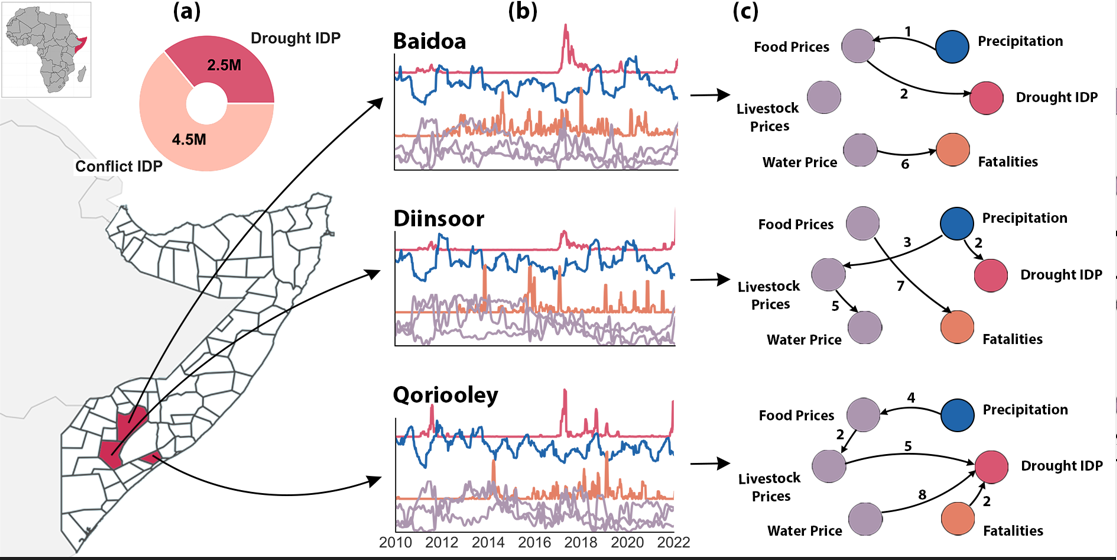


# Dataset

The input data includes varied data sources, environmental and climatic variables from Earth Observation data, including the precipitation dataset captured from Climate Hazards center InfraRed Precipitation with Station data (CHIRPS) as well as the Potential Evaporation and the Volumetric Soil Water Layers (1-4) from ERA5LAND and the ESA CCI landcover.
Socioeconomic non-EO datasources, like the price of commodities (e.g. sorghum, maize, etc.) , water and livestock (for instance, Cattle, Camel, etc.) are included, together with the violent conflict data captured from the Armed Conflict Location & Event Data Project (ACLED).  The target variable dataset of Internal Displacement in Somalia is obtained via United Nations High Commissioner for Refugees (UNHCR) Protection & Return Monitoring Network (PRMN) with time series ranges 2016-ongoing at weekly intervals. 

Data availability, reliability and quality influence the model training and causal discovery. Caveats including incompleteness, sparsity, reduced number of samples were identified. Where it was not possible to apply curation strategies through data cleaning and preprocessing or to achieve harmonization requirements, the data was finally discarded. 

The UC2 demo notebook makes use of the following data aggregated at a weekly time-frame at a district level:  

**EO datasets**

| Dataset    | Variable                                 | Spatial resolution | Temporal resolution |
|------------|---------------------------------------------|--------------------|---------------------|
| ERA5LAND   | Potential Evaporation                       | 0.1º               | daily               |
| ERA5LAND   | Volumetric Soil Water Layers (1-4)          | 0.1º               | daily               |
| CHIRPS     | Infrared Precipitation with station data    | 0.05º              | daily               |
| ESSA CCI LC | Land Cover                                  | 300m               | yearly              |


**NON-EO datasets**

| Dataset                   | Variable                           | Spatial resolution      | Temporal resolution |
|---------------------------|---------------------------------------|-------------------------|---------------------|
| IDP (UNHCR PRMN)          | Drought Internal Displacement          | Administrative Level 2  | Weekly              |
| FSNAU Market Prices                     | Market Prices Data                     | Local Market            | Monthly             |
| ACLED                     | Violent Conflict Data                  | Points                  | Event-wise          |
| UNDP Somalia Regions      | District Polygon Layer                 | Administrative Level 1  | Static              |
| UNDP Somalia Districts    | District Polygon Layer                 | Administrative Level 2  | Static              |
| FEWS NET LZ               | Livelihood Zone Polygon Layer          | Shapefile               | Static              |




## Notebook outline
* [1 - Import libraries & dependencies](#import_libraries)
* [2 - Data load](#load_data)
* [3 - Data pre-processing & feature selection](#data_preparation_feature_selection)
   * [3.1 - Extraction of Drought Index in croplands](#Drought_Index)
   * [3.2 - Market prices pre-processing](#Market_prices)
      * [3.2.1 - Select commodities across local markets](#Select_best_market_prices)
      * [3.2.2 - Compute Minimum Expenditure Basket and Livestock Price Index](#Compute_MEB)
      * [3.2.3 - Correction market prices inflation and interpolation](#Correction_market_prices)
   * [3.3 - Conflict and Displacement data](#Prepare_IDP)
* [4 - Causal Discovery for Drought Displacement Timeseries](#Methods)
* [5 - Random Forest prediction models from causal parents](#Forecasting)
* [6 - DeepCube technologies](#DeepCube_technology)
* [7 - Remarks and conclusion](#Remarks)
* [8 - References](#Reference)


## <a id='import_libraries'></a>1. Import libraries & dependencies

In this section the libraries and dependencies requested are imported.

In [ ]:
# You may need to install this libraries 
# activate ipywidgets in your notebook environment

!pip install bqplot >/dev/null
!pip install ipyleaflet >/dev/null
!pip install tigramite >/dev/null

In [3]:
# Import dependencies
import json
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcol
from bqplot import Lines, Figure, LinearScale, DateScale, Axis, Scatter
from ipyleaflet import Map, GeoJSON, WidgetControl, Choropleth, basemaps
from ipywidgets import Dropdown, Layout, HTML, Text
from branca.colormap import linear
from matplotlib.pyplot import figure
import geopandas as gpd

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc import GPDC

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


c:\Users\chema\anaconda3\envs\Causality4DroughtDisplacement\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## <a id='load_data'></a>2. Data load

In this section we plot an `interactive map` in which the user can select an aggregation level within Somalia in which a the causal graph will be extracted. 
Colors in the map indicate the total sum of internally displaced population due to drought 

Two aggregation levels are available in the public notebook: 

> - `'District'`
> - `'Region'`



In [5]:
#%% Select Aggregation Level
Aggregation_level = 'Region'

#%% Load UC2 datacube
UC2_cube = xr.open_dataset('UC2_public_datacube.nc')

print('Selected ' + Aggregation_level + ' aggregation level')

UC2_cube


Selected Region aggregation level


<xarray.Dataset>
Dimensions:              (latitude: 136, longitude: 104, time: 2706)
Coordinates:
  * latitude             (latitude) float32 -1.6 -1.5 -1.4 ... 11.7 11.8 11.9
  * longitude            (longitude) float32 41.0 41.1 41.2 ... 51.1 51.2 51.3
  * time                 (time) datetime64[ns] 2016-01-01 ... 2023-05-29
Data variables: (12/31)
    Livelihood           (latitude, longitude) float64 ...
    spatial_ref          int32 ...
    Region               (latitude, longitude) float64 ...
    District             (latitude, longitude) float64 ...
    t2m                  (latitude, longitude, time) float32 ...
    pev                  (latitude, longitude, time) float32 ...
    ...                   ...
    Water Drum Price     (latitude, longitude, time) float64 ...
    Cattle Price         (latitude, longitude, time) float64 ...
    Camel Price          (latitude, longitude, time) float64 ...
    Goat Price           (latitude, longitude, time) float64 ...
    SomaliShillingToUSD  (latitude, longitude, time) float64 ...
    SomalilandShToUSD    (latitude, longitude, time) float64 ...

In [6]:
#%%% Plot interactive map:

if Aggregation_level == 'District':
    ts_dataframe = pd.read_csv('District_display_data.csv')
    ts_dataframe = ts_dataframe.set_index('time')
    with open('Admin2_Map_UNDP.geojson', 'r') as f:
        admin2_map = json.load(f)
        for p in admin2_map['features']:
            p['id'] = p['properties']['admin2Name']
    shapefile_map = admin2_map
    selected_area = 'Baidoa'
    property = 'admin2Name' 

if Aggregation_level == 'Region':
    ts_dataframe = pd.read_csv('Region_display_data.csv') 
    ts_dataframe= ts_dataframe.set_index('time')
    with open('Admin1_Map_UNDP.geojson', 'r') as f:
        admin1_map = json.load(f)
        for p in admin1_map['features']:
            p['id'] = p['properties']['ADM1_EN']
    shapefile_map = admin1_map
    selected_area = 'Bay'
    property = 'ADM1_EN'

date_start = min(ts_dataframe.index) 
date_end = max(ts_dataframe.index)

from datetime import datetime
start = datetime.strptime("01/01/2016","%d/%m/%Y")
end = datetime.strptime("25/04/2023","%d/%m/%Y")

date_scale = DateScale(min=start, max=end)
date_data = pd.date_range(start=date_start, end=date_end, freq='w', normalize=True)

data_name = 'SPEI_6M'

# IDP figure: 
view = 'IDP_Drought' 
IDP_data = ts_dataframe[ts_dataframe[Aggregation_level] == selected_area][view].values

x_scale_IDP = LinearScale()

scatter_IDP = Scatter(x=date_data, y=IDP_data, scales={'x': date_scale, 'y': x_scale_IDP}, default_size = 10)

ax_x_idp = Axis(label='Date', scale=date_scale, num_ticks=10, tick_format='%Y')
ax_y_idp = Axis(label=view, scale=x_scale_IDP, orientation='vertical', side='left')

figure_IDP = Figure(axes=[ax_x_idp, ax_y_idp], title=selected_area, marks=[scatter_IDP], animation_duration=0,
                layout={'min_height': '150px', 'min_width': '800px', 'max_height': '350px'})

def update_IDP_figure(selected_area):
    scatter_IDP.y = ts_dataframe[ts_dataframe[Aggregation_level] ==  selected_area][view]
    ax_y_idp.label = view.capitalize()
    figure_IDP.title = selected_area

# Data Figure:
x_data = ts_dataframe[ts_dataframe[Aggregation_level] == selected_area][data_name].values
x_scale_data = LinearScale()

lines = Lines(x=date_data, y=x_data, scales={'x': date_scale, 'y': x_scale_data})
scatter = Scatter(x=date_data, y=x_data, scales={'x': date_scale, 'y': x_scale_data}, default_size = 10)

plot_method = lines #scatter 
# plot_method = scatter #scatter 

ax_x_data = Axis(label='Date', scale=date_scale, num_ticks=10, tick_format='%Y')
ax_y_data = Axis(label=data_name.capitalize(), scale=x_scale_data, orientation='vertical', side='left')

figure_data = Figure(axes=[ax_x_data, ax_y_data], title=data_name, marks=[plot_method], animation_duration=50,
                layout={'min_height': '150px', 'min_width': '800px', 'max_height': '350px'})


def update__data_figure(selected_area, data_name):  
    plot_method.y = ts_dataframe[ts_dataframe[Aggregation_level] == selected_area][data_name].values
    ax_y_data.label = data_name.capitalize()
    figure_data.title = 'SPEI 6 Months'
    
# Update both figures
update__data_figure(selected_area, data_name)
update_IDP_figure(selected_area)

m = Map(zoom=6.2, center = (5,53), zoom_control= False, double_click_zoom = False, layout={'min_height': '800px', 'min_width': '1000px'})

def minmax(x):
    return (x-min(x)) /(max(x)-min(x))

from scipy.stats import entropy
suma= minmax(ts_dataframe.groupby(Aggregation_level)[view].apply(lambda x: sum(x.dropna())))

score_district_plot = suma

idp_sums =  dict(zip(score_district_plot.index.to_list(), score_district_plot.reset_index()[view].to_list()))

layer = Choropleth(
    geo_data=shapefile_map,
    choro_data=idp_sums,
    colormap=linear.YlOrRd_05,
    # colormap=colormap,
    key_on= 'id',
    style={'fillOpacity': 0.8, 'dashArray': '5, 5'}
)

m.add_layer(layer)

geo = GeoJSON(data=shapefile_map, style={'fillColor': 'white', 'weight': 1}, hover_style={'fillColor': 'black'}, name='Districts')

m.add_layer(geo)

html = HTML('''''')
html.layout.margin = '0px 10px 10px 10px'
control = WidgetControl(widget=html, position='topleft')
m.add_control(control)

def update_html(feature, id, **kwargs):
    html.value = '''
        District name:  
        <b>{}
    '''.format(id)

geo.on_hover(update_html)

widget_control1 = WidgetControl(widget=figure_IDP, position='topright')
widget_control2 = WidgetControl(widget=figure_data, position='bottomright')

m.add_control(widget_control1)
m.add_control(widget_control2)

update_IDP_figure(selected_area)
update__data_figure(selected_area, data_name)

def choose_district(event, feature, **kwargs):
    global selected_area
    selected_area = feature['properties'][property]
    
    update__data_figure(selected_area, data_name)
    update_IDP_figure(selected_area)

geo.on_click(choose_district)

def on_click(change):
    global data_name, plot_method

    data_name = change['new']
    update__data_figure(selected_area, data_name)

m


Map(center=[5, 53], controls=(AttributionControl(options=['position', 'prefix'], position='bottomright'), Widg…

## <a id='data_preparation_feature_selection'></a>3. Data pre-processing & feature selection

Pre-processing in UC2 has application of gap filling, dropping non-complete features, selection of the best market commodities within an area, correction of inflation in market prices and windowing variables to account for accumulated effects.

All data is scaled to a weekly time-series resolution at the chosen aggregation level. 



In [19]:
# Select area from cube:

print('Selected area is ' + selected_area + ' ' + Aggregation_level)

area_names = UC2_cube[Aggregation_level].attrs[Aggregation_level+'_Name']
region_names =  UC2_cube['Region'].attrs['Region_Name']

selected_data = UC2_cube.where(UC2_cube[Aggregation_level] == area_names.index(selected_area), drop=True)


Selected area is Bay Region


### <a id='Drought_Index'></a> 3.1 Extraction of Drought Index on croplands

Somali households in the most drought-affected areas in Somalia greatly depend on crop yield. this is specially true for agropastoralist households in Bay o region. 

Using the datacube technologies we can `extract the SPEI index only in croplands` using the ESA CCI landcover. 



<AxesSubplot:xlabel='time'>

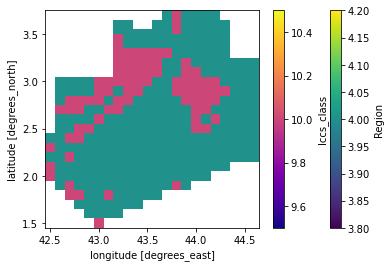

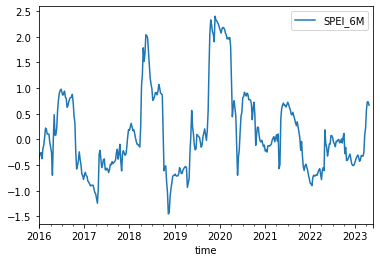

In [8]:
# Extract drought Index from cube: SPEI in croplands
from aux_functions import mode
lc_names = UC2_cube.lccs_class.flag_meanings.split(' ') 
lc_values = UC2_cube.lccs_class.flag_values[[1,2,3,4,5]]
lc_mode = mode(UC2_cube.lccs_class, dim='time')
lc_mask = selected_data.where(lc_mode.isin(lc_values), drop=True)

selected_data.Region.plot()
mode(lc_mask.lccs_class, dim='time').plot(cmap = "plasma")

# SPEI Spatial Mean in mask
SPEI = lc_mask.SPEI_6M.mean(dim=('latitude', 'longitude'))
SPEI = SPEI.to_dataframe().reset_index().resample('W-MON', label='left', closed = 'left', on='time').mean()
SPEI.plot()


### <a id='Market_prices'></a> 3.2 Market prices pre-processing

#### <a id='Select_best_market_prices'></a> 3.2.1 Select the best commodities across local markets 

It is estimated that around 66% of Somalia's GDP is based on an agricultural and livestock economy. Hence, market prices data show supply and demand shocks of food availability, the quality of livestock as well as other possible dynamics due to agricultural failure and desertification of pasture lands.

Due to data quality reasons, here we `select the best data across markets`. 

We use a ordinal variance criteria which allows us to account for missing values and repeated values across the timeseries.


 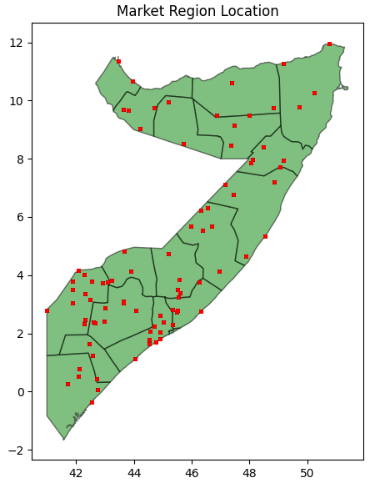

In [10]:
#%% Select best commodities 
market_prices_vars = ['District', 'Red Sorghum Price', 'Wheat Flour Price', 'Sugar Price', 'Vegetable Oil Price', 'Camel Milk Price', 
                    'Tea Leaves Price', 'Salt Price', 'Cowpeas Price', 'Water Drum Price', 'Cattle Price', 'Camel Price', 'Goat Price', 'SomaliShillingToUSD']

market_data = selected_data[market_prices_vars].to_dataframe()
commodities = market_prices_vars[1:]

data = []
# Group by 'District' and iterate over each commodity
for district, group in market_data.groupby('District'):
    for commodity in commodities:
        ord_enc = OrdinalEncoder()
        if any(group[commodity].notnull()):
            market_enc = ord_enc.fit_transform(np.array(group[commodity].dropna()).reshape(-1, 1)).astype(int)
            variance = np.var(np.unique(market_enc.flatten()))
            data.append([commodity, variance, district])

# Create a DataFrame from the data list
df_variance_scores = pd.DataFrame(data, columns=['Commodity', 'Variance Score', 'District'])

# Print the DataFrame
df_best_scores = df_variance_scores.groupby('Commodity')['Variance Score'].idxmax()
df_best_commodities = df_variance_scores.loc[df_best_scores]

# Select the best commodity across districts:
market_prices_best = pd.DataFrame()
for commodity in commodities:
    best_district = df_best_commodities[df_best_commodities['Commodity'] == commodity]['District']

    if len(best_district) > 0:
        best_district = best_district.values[0]
        market_prices_best[commodity] = market_data[market_data['District'] == best_district][commodity].reset_index('time').groupby(['time']).mean().dropna()

market_prices_best

,Red Sorghum Price,Wheat Flour Price,Sugar Price,Vegetable Oil Price,Camel Milk Price,Tea Leaves Price,Salt Price,Cowpeas Price,Water Drum Price,Cattle Price,Camel Price,Goat Price,SomaliShillingToUSD
time,,,,,,,,,,,,,
2016-01-31,4575.0000,22000.0000,20000.0000,42000.0000,16200.0000,35000.0000,10000.0000,10400.0000,20000.0000,4.060000e+06,9.800000e+06,9.060000e+05,22880.0000
2016-02-29,3318.1818,22035.0877,23771.9298,42614.0351,15614.0351,33403.5088,10526.3158,13526.3158,20438.5965,3.818421e+06,9.875439e+06,1.079474e+06,23235.0877
2016-03-31,2150.0000,20000.0000,20000.0000,41000.0000,15000.0000,34000.0000,15500.0000,10500.0000,20000.0000,4.575000e+06,1.075000e+07,1.057500e+06,23050.0000
2016-04-30,2220.0000,18000.0000,20000.0000,40200.0000,11600.0000,34200.0000,10000.0000,13200.0000,20000.0000,4.320000e+06,1.042000e+07,1.162000e+06,23220.0000
2016-05-31,2575.0000,18000.0000,20000.0000,42500.0000,13500.0000,36000.0000,10000.0000,13500.0000,20000.0000,3.425000e+06,9.775000e+06,1.077500e+06,23175.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,9000.0000,32000.0000,32000.0000,60000.0000,25250.0000,40000.0000,18000.0000,45000.0000,30000.0000,4.000000e+06,1.000000e+07,9.875000e+05,27000.0000
2022-12-31,8500.0000,31200.0000,31600.0000,60000.0000,24000.0000,37000.0000,18000.0000,42800.0000,NaN,4.040000e+06,1.010000e+07,1.070000e+06,27000.0000
2023-01-31,8000.0000,27750.0000,29500.0000,57750.0000,26500.0000,35000.0000,18000.0000,40000.0000,NaN,4.125000e+06,1.015000e+07,1.150000e+06,27000.0000


#### <a id='Cmpute_MEB'></a> 3.2.2 Compute Minimum Expenditure Basket and Livestock Price Index

To summarize the different commodities into a single index depicting the food security situation, humanitarian agencies often compute a minimum expenditure basket. This basket accounts 

LASPEYRES FOOD PRICE INDEX = 100 * (∑ wn Pr)/ ∑ wn

where wn is the budget share of the different commodities that form the food basket

FSNAU calculates CPI as the average percentage change in the current MEB Cost in reference to the March 2007 MEB Cost.

Reference: https://fsnau.org/downloads/FSNAU-CMB-CPI-for-Somalia.pdf

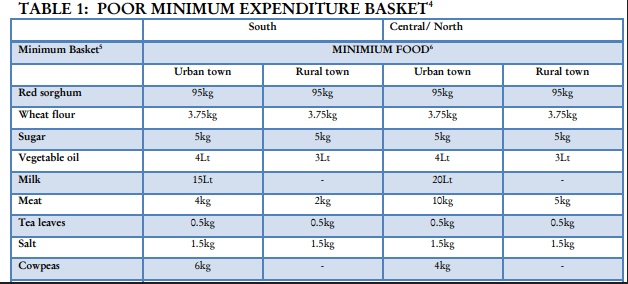


A similar approach is carried out by weighting different livestock prices according to their contribution to the ecconomy in each region.

Influence of livestock prices on drought displacement is clear, tons of people depend on livestock breeding as their main livelihood (through exports and crafts).

Reference: https://www.au-ibar.org/sites/default/files/2020-11/20160610_final_report_contribution_livestock_somalia_gdp_en.pdf


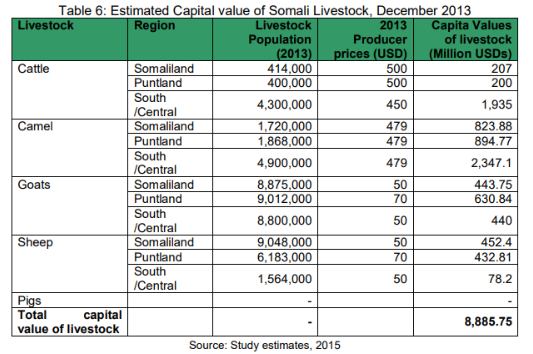

<AxesSubplot:title={'center':'Consumer Minimum Basket index'}, xlabel='time'>

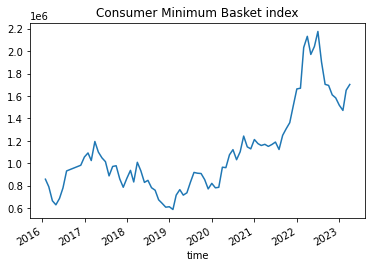

In [11]:
#%% Compute MEB and Livetock Price Index:
MEB = market_prices_best[['Red Sorghum Price', 'Wheat Flour Price', 'Sugar Price', 'Vegetable Oil Price', 'Camel Milk Price', 'Tea Leaves Price','Salt Price', 'Cowpeas Price']]
MEB = MEB.dropna(axis=1, how='all')

weights = [95, 3.75, 5, 4, 15, 0.5, 1.5, 6]
CMB = (MEB * weights).sum(axis = 1) / np.array(weights).sum() * 100
CMB.replace(0, np.nan, inplace=True)

commodities = ['Red Sorghum Price', 'White Maize Price', 'Sugar Price', 'Vegetable Oil Price', 'Camel Milk Price', 'Tea Leaves Price','Salt Price', 'Cowpeas Price']

# Correct for currency devaluation:
water = market_prices_best['Water Drum Price']

# Cattle, Camel, Goats weights per region:
south_central = ['Banadir', 'Bakool', 'Bay', 'Gedo', 'Galgaduud','Hiraan', 'Middle Juba', 'Lower Juba', 'Middle Shabelle', 'Lower Shabelle']
puntland = ['Bari', 'Mudug', 'Nugaal']          
somaliland=['Awdal', 'Togdheer', 'Sanaag',  'Sool','Woqooyi Galbeed']

# Weights for the Livestock Prices:
region = region_names[np.unique(selected_data.Region.to_dataframe().dropna()).astype(int)[0]]
if region  in south_central:
    area = 'South Central'
if region  in puntland:
    area = 'Puntland'
if region  in somaliland:
    area = 'Somaliland'

if area == 'South Central':
    south_central_total = 1935+2347+440
    region_weights = [1935 / south_central_total, 2347 / south_central_total, 440 / south_central_total]
if area == 'Puntland':
    puntland_total = 200+894+630
    region_weights = [200 / puntland_total, 894 / puntland_total, 630 / puntland_total]
if area == 'Somaliland':
    somaliland_total = 207+823+443
    region_weights = [207 / somaliland_total, 823 / somaliland_total, 443 / somaliland_total]

livestock = market_prices_best[['Cattle Price' , 'Camel Price', 'Goat Price']]

if livestock['Cattle Price'].isnull().all():
    region_weights = region_weights[1:]
    
livestock = livestock.dropna(axis=1, how='all')
livestock_usd_prices = livestock

# Normalize and weight by region capital values of livestock
livestock_usd_prices = (livestock_usd_prices-livestock_usd_prices.min())/(livestock_usd_prices.max()-livestock_usd_prices.min())
livestock_weighted = (livestock_usd_prices * region_weights)
livestock_index = livestock_weighted.sum(axis = 1) / np.array(region_weights).sum() * 100
livestock_index.replace(0, np.nan, inplace = True)

CMB.name = 'Food Prices'
livestock_index.name = 'Livestock Prices'
water.name = 'Water Prices'

CMB.plot(title='Consumer Minimum Basket index')


####  <a id='Correction_market_prices'></a> 3.2.3 Correction market prices inflation and interpolation

For this task, the currency inflation of commodites is crearly visible and likely to influence results.

We convert the prices into nominal prices by using exchange rate data of the Somali Shilling/USD

Lastly, market prices time-series interpolation is applied using a quadratic interpolation (order 2).

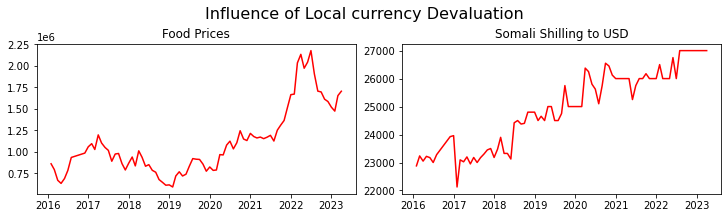

In [12]:

date_market = '2016'
market_prices = pd.concat([CMB, livestock_index, water], axis = 1)

deflate = True

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (10,5), constrained_layout=True)
ax1 = plt.subplot(221)
ax1.set_title('Food Prices')
ax1.plot(market_prices['Food Prices'], color='red')
ax2 = plt.subplot(222)
ax2.plot(market_prices_best['SomaliShillingToUSD'], color='red')
ax2.set_title('Somali Shilling to USD')
fig.suptitle('Influence of Local currency Devaluation', fontsize=16)


if deflate:
    if area == 'Somaliland':
        market_prices = market_prices.divide(market_prices_best.SomalilandShToUSD.loc[date_market:], axis = 0)
        # market_prices = pd.concat([market_prices, market_prices_best.SomalilandShToUSD.loc[date_market:]], axis = 1)
        
    else:  
        market_prices = market_prices.divide(market_prices_best.SomaliShillingToUSD.loc[date_market:], axis = 0) 
        # market_prices = pd.concat([market_prices, market_prices_best.SomaliShillingToUSD.loc[date_market:]], axis = 1)


# Prices in the midel of the month
market_prices= market_prices.resample('W-MON', label='left', closed = 'left').mean().shift(2)
market_prices_interp = market_prices.interpolate(method='polynomial', order=2)


#### <a id='Prepare_IDP'></a> 3.3 Conflict and Displacement data 

In this last step we impute missing values with 0 and smooth the timeseries using a summing window of a month. 

The `Drought-IDP` variable is gap-filled by imputing 0 on missing values. 

- This step is based on the approximation that UNHCR actors move to an affected district when siginificant displacement waves are happening within a region, so significant moves are not lost within the imputation.

- Other tests such as regression models and subsequently testing only on true values were conducted to ensure this method reliability.

The final harmonized dataset is displayed.

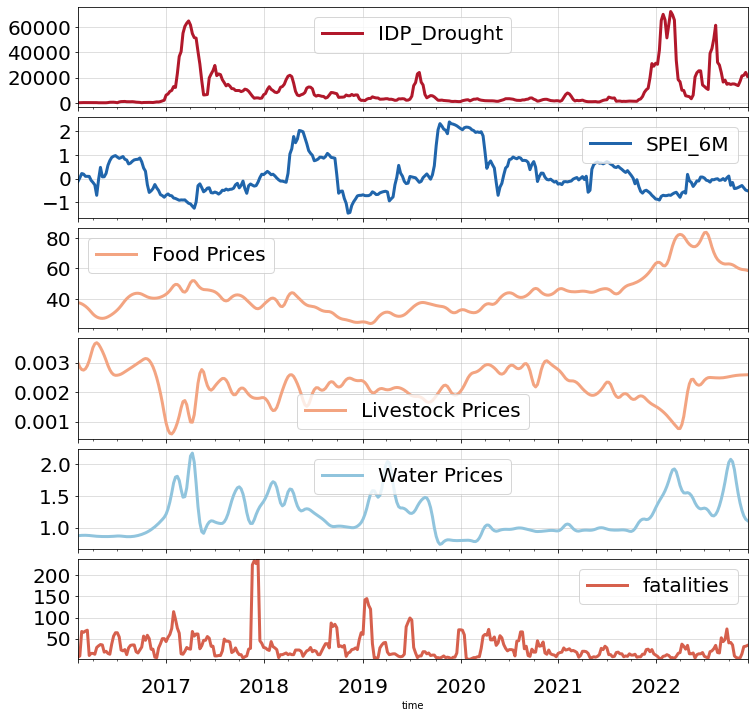

In [13]:
from aux_functions import build_win_feature, build_lag_feature

#%% Displacement and fatalities data
IDP_drought = selected_data.IDP_Drought.sum(dim=['latitude', 'longitude']).to_dataframe().resample('W-MON', label='left', closed = 'left').sum()
Fatalities =  selected_data.fatalities.sum(dim=['latitude', 'longitude']).to_dataframe().resample('W-MON', label='left', closed = 'left').sum()

IDP_drought = IDP_drought.fillna(0).rolling(4).sum()
Fatalities = Fatalities.fillna(0).rolling(4).sum()

DATA = pd.concat([IDP_drought, SPEI, market_prices_interp[['Food Prices', 'Livestock Prices', 'Water Prices']], Fatalities],axis = 1).dropna()

# Plot Final Data

fig, axes = plt.subplots(len(DATA.columns), 1, figsize=(12, 12),  sharex=True, rasterized = True)
axe = axes.ravel()

color = iter(mpl.cm.RdBu_r([0.9 , 0.1, 0.7 , 0.7, 0.3, 0.8, 0.95, 1 ]))

# assign the plot to each subplot in axe
for i, t in enumerate(DATA.columns):
    c = next(color)
    DATA[t].plot(ax=axe[i], linewidth=3, c= c, fontsize  = 20)

    axe[i].legend([t], loc = 'best', fontsize  = 20)
    axe[i].yaxis.set_tick_params(labeltop=False)
    axe[i].axes.get_xaxis().set_visible(True)
    axe[i].tick_params(axis='x', which='major', pad=15)  
    axe[i].grid(True, alpha=0.5)
    if t == 'Violent Conflict':
        axe[i].axes.get_xaxis().set_visible(True)
        axe[i].tick_params(axis='x', which='major', pad=15, labelsize =50)  

fig.subplots_adjust(wspace=0, hspace=0.1)
plt.margins(x=0, y = 0)



## <a id='Methods'></a>4. Causal Discovery for Drought Displacement Timeseries: 

In this section, we will give an overview of the modelling methods that are used. 

Our goal is to discover potential causal links[1][2][3][4] between the variables without strong prior-assumptions on data distributions and use the parent variables to build a causal ranking to rank the most important features

* Causal inference:

Here we employ `PCMCI` [5] method which allows to extract causal graphs from high-dimensional time series, model the obtained causal dependencies, infer causal links as well as the time-lags dependencies in which the variables are affecting each other

To extract a causal graph from data, the main objective of UC2, we used PCMCI algorithm, a causal inference method for time-series analysis. This method is able to compute links of the variables that are causally affecting each other, temporal lags and determine the strength of the causal links.

To apply the `PCMCI` algorithm, time-lag 𝛕 and significance level α parameters must be set: 

For the UC2, a maximum lag of 8 weeks was used, which accounts for the duration of rainy seasons in Somalia. 

> This is due to the knowledge that rainy seasons in Somalia determine agricultural failure or availability of grazing land for livestock, which in turn will affect people's livelihood and in the extreme case, cause the displacement waves.

We chose an α parameter of 0.05 for the causal link significance, the standard significance level consensus in evidential statistics.

As an indepence test criterion we will choose partial correlation which will return significant dependencies with p-values < 0.1.


In [14]:
def pcmci_graph(DATA, cond_ind_test, tau_min,  tau_max, alpha_level, pc_alpha):
    
    labels = list(DATA.columns)
    labels = [label.split(' w')[0] for label in labels]
    all_data_array = np.array(DATA, dtype = float)
    var_names = labels
    dataframe = pp.DataFrame(all_data_array, datatime = np.arange(len(all_data_array)), var_names=var_names)

    N = len(var_names)

    # Nothing can cause precipitation: masking precipitation links
    link_assumptions = {j:{(i, -tau):'o?o' for i in range(N) for tau in range(1,tau_max + 1) if (i, -tau) != (j, 0)} 
                                for j in range(N)}

    link_assumptions[1] = {(i, -tau):'-?>' for i in range(N) for tau in range(1,tau_max + 1)
                        if ((i, -tau) not in [(1,0),(1,2),(1,3),(1,4),(1,5)] and i not in [0,1, 2, 3, 4, 5])} 
                            
    lvTmp = np.linspace(0.1,0.8,(256)-1)
    cmTmp = mpl.cm.OrRd(lvTmp)
    newCmap = mcol.ListedColormap(cmTmp)

    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test, verbosity=0) 
    results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=pc_alpha, alpha_level=alpha_level, link_assumptions=link_assumptions) 
    q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method=None, exclude_contemporaneous=False)

    graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=alpha_level, 
                tau_min=0, tau_max=tau_max)

    results['graph'] = graph

    # Plot causal graph
    tp.plot_graph(
        val_matrix=results['val_matrix'],
        graph=results['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        label_fontsize = 20,
        figsize=(18,12), node_label_size = 30, node_size  =0.5, link_label_fontsize =20, arrow_linewidth=10,cmap_edges = 'RdBu_r', cmap_nodes = newCmap, 
        vmin_nodes = 0, vmax_nodes = 1, node_ticks = 0.5, edge_ticks = 0.5, show_colorbar =  True, node_aspect = None, curved_radius  = 0.2, 
        ); 

    plt.show()

    return results

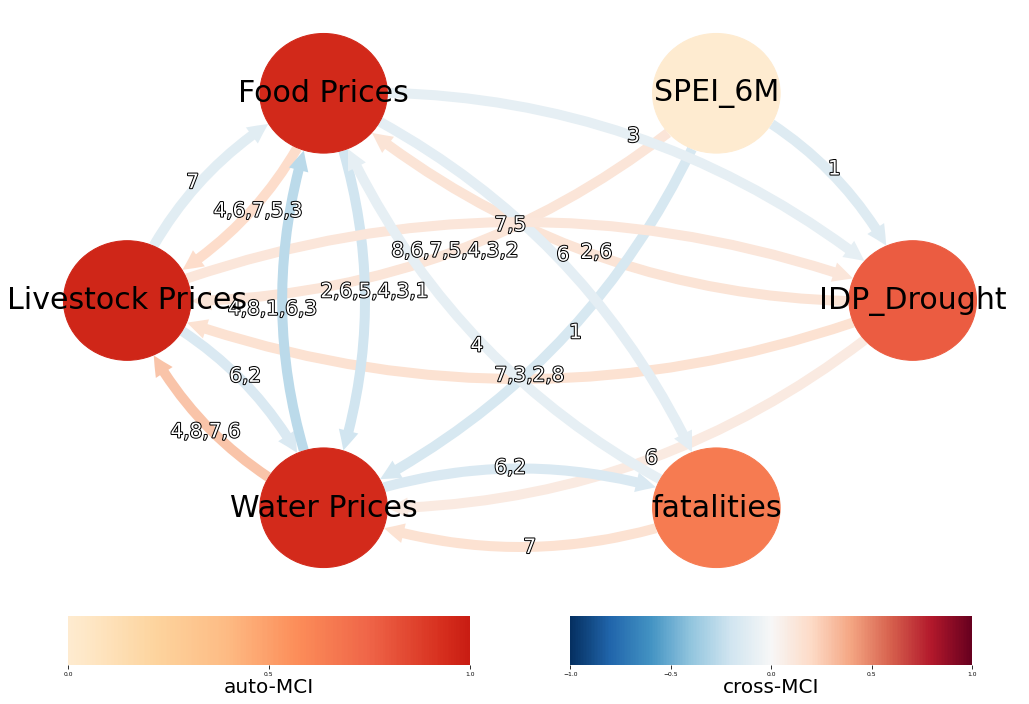

In [15]:
# PCMCI Params

tau_max = 8
tau_min =1

alpha_level= 0.1
pc_alpha = 0.05

cond_ind_test = ParCorr(verbosity=0)

parcorr_pcmci = pcmci_graph(DATA = DATA, cond_ind_test = cond_ind_test, tau_min = tau_min,  tau_max = tau_max, alpha_level = alpha_level, pc_alpha = pc_alpha)


## <a id='Forecasting'></a>5 Random Forest prediction models from causal parents

In this step we will use the causal parents to predict the last drought displacement waves by fitting a random forest model.




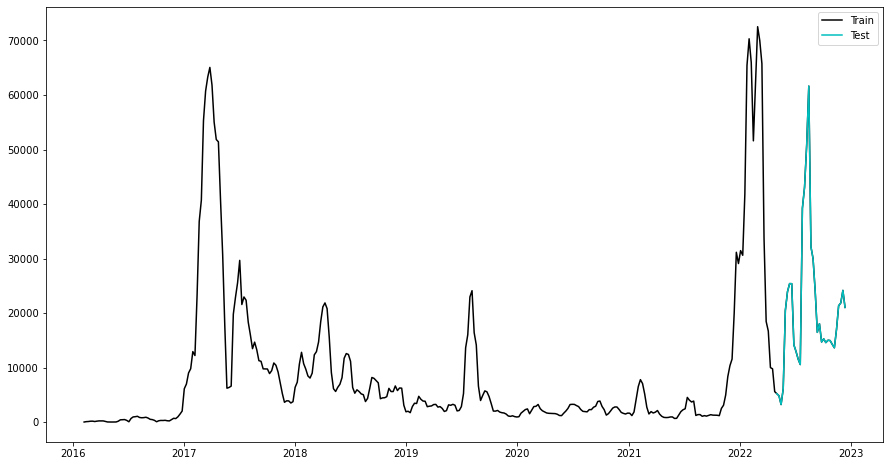

In [16]:
# Build causal feature dataframe from causal parents found in PCMCI

from aux_functions import build_win_feature, build_lag_feature
link_matrix = parcorr_pcmci['graph']

causal_lags = [[i for i, val in enumerate(link[0]) if val] for link in link_matrix][1:]
labels = DATA.columns
Causal_labels = labels[1:]
Causal_Data = pd.DataFrame()

for feat_idx in range(0,len(Causal_labels)):
    
    feature = Causal_labels[feat_idx]
    Causal_Data['IDP_Drought'] = DATA['IDP_Drought']
    
    if causal_lags[feat_idx]:
        
        lags = causal_lags[feat_idx]
        for lag in lags:
            name = feature + ' Lag' + str(lag)
            Causal_Data[name]= DATA[feature].shift(lag)

Causal_Data = Causal_Data.dropna()


# Build dataframe with non-causal variables
lags = [1,2,3,4,5,6,7,8]

All_Causal_Data = DATA.iloc[:,1:]
All_Causal_Data = build_lag_feature(All_Causal_Data, lags).iloc[:,5:]

All_Causal_Data = pd.concat([DATA.iloc[:,0], All_Causal_Data], axis = 1)
All_Causal_Data = All_Causal_Data.dropna() 

# Z-score and set trai/test set. We aim to predict the last wave
from scipy.stats import zscore
Causal_Data.iloc[:,1:] = Causal_Data.iloc[:,1:].apply(zscore)

# wave4 = Causal_Data.loc['Sep-2020':'Jan-2022']
wave4 = Causal_Data.loc['May-2022':]
wave4_all = All_Causal_Data.loc['May-2022':]

# Train-Test sets: Displacement waves
fig, axes = plt.subplots(1, 1, figsize=(15, 8),  sharex=True)
plt.plot(DATA['IDP_Drought'].index, DATA['IDP_Drought'], color = 'k')
plt.plot(wave4.index, wave4['IDP_Drought'], color = 'c')
plt.legend(['Train', 'Test'])

# Define train-test sets for causal data:
wave4_train = Causal_Data.loc[~Causal_Data.index.isin(wave4.index)]
wave4_test = Causal_Data.loc[Causal_Data.index.isin(wave4.index)]

# Define train-test sets for non-causal data:
wave4_train_all = All_Causal_Data.loc[~All_Causal_Data.index.isin(wave4_all.index)]
wave4_test_all = All_Causal_Data.loc[All_Causal_Data.index.isin(wave4_all.index)]

R2 Causal = 0.11952519111580763
NRMSE Causal = 0.938042907998727
R2 Non-Causal = -0.23140022017172499
NRMSE Non-Causal = 1.1087665196230199


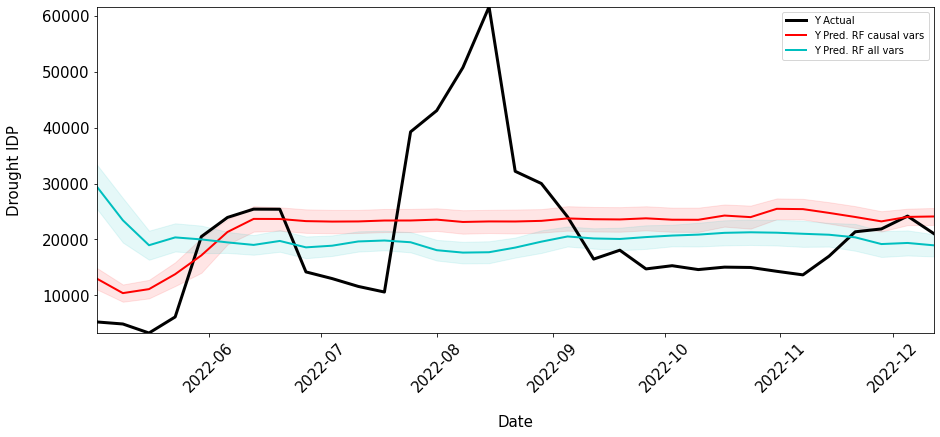

In [28]:
#%% Train 100 Random Forest models for confidence intervals:

R_tot = []
NRMSE_tot = []
Y_pred_tot = []
for i in range(0,100):
    
    rf_causal = RandomForestRegressor(n_estimators = 30, max_depth=32)
    X_train, X_test, Y_train, Y_test = (wave4_train.iloc[:,1:], wave4_test.iloc[:,1:], wave4_train.iloc[:,0], wave4_test.iloc[:,0])
    # Train the model on training data
    rf_causal.fit(X_train, Y_train)
    # Regress
    y_pred=rf_causal.predict(X_test)
    NRMSE = mean_squared_error(Y_test, y_pred , squared=False) / np.std(Y_test)
    model_score_R = r2_score(Y_test, y_pred, sample_weight=None, multioutput='uniform_average')
    R_tot.append(model_score_R)
    NRMSE_tot.append(NRMSE)
    Y_pred_tot.append(y_pred)

Y_pred_mean = np.mean(Y_pred_tot, axis = 0)
Y_pred_std = np.std(Y_pred_tot, axis = 0)
print('R2 Causal = ' + str(np.mean(R_tot)))
print('NRMSE Causal = ' + str(np.mean(NRMSE_tot)))

# choose wave: 
R_tot = []
NRMSE_tot = []
Y_pred_tot = []
for i in range(0,100):

    rf_all = RandomForestRegressor(n_estimators = 30, max_depth=32)
        
    X_train, X_test, Y_train, Y_test = (wave4_train_all.iloc[:,1:], wave4_test_all.iloc[:,1:], wave4_train_all.iloc[:,0], wave4_test_all.iloc[:,0])

    # Train the model on training data
    rf_all.fit(X_train, Y_train)
    # Regress
    y_pred_all=rf_all.predict(X_test)

    # NRMSE = (np.abs(Y_test - y_pred_all).mean()/Y_test.std
    NRMSE = mean_squared_error(Y_test, y_pred_all , squared=False) / np.std(Y_test)
    model_score_R = r2_score(Y_test, y_pred_all, sample_weight=None, multioutput='uniform_average')
    
    R_tot.append(model_score_R)
    NRMSE_tot.append(NRMSE)
    Y_pred_tot.append(y_pred_all)

Y_pred_mean_all = np.mean(Y_pred_tot, axis = 0)
Y_pred_std_all = np.std(Y_pred_tot, axis = 0)
print('R2 Non-Causal = ' + str(np.mean(R_tot)))
print('NRMSE Non-Causal = ' + str(np.mean(NRMSE_tot)))

fig, axes = plt.subplots(1, 1, figsize=(15, 6),  sharex=True)
# True data
plt.plot(Y_test.index, Y_test, label = 'Y Actual', color = 'k', lw = 3)
# RF causal
plt.plot(Y_test.index, Y_pred_mean, label = 'Y Pred. RF causal vars', color = 'r', lw = 2)
plt.fill_between(Y_test.index, Y_pred_mean - Y_pred_std, Y_pred_mean + Y_pred_std, color='r', alpha=0.1)
# RF all
plt.plot(Y_test.index, Y_pred_mean_all, label = 'Y Pred. RF all vars', color = 'c', lw = 2)
plt.fill_between(Y_test.index, Y_pred_mean_all - Y_pred_std_all, Y_pred_mean_all + Y_pred_std_all, color='c', alpha=0.1)
plt.xlabel('Date',labelpad = 20, fontsize = 15)
plt.ylabel('Drought IDP', labelpad = 20, fontsize = 15)
plt.xticks(fontsize=15, rotation  = 45)
plt.yticks(fontsize=15)
plt.legend()
plt.margins(x=0, y = 0)


## <a id='DeepCube_technology'></a>6. DeepCube technologies

The following technologies might make use of UC2 inputs and contribute to the implementation of research studies:

> 1:  **Earth System data cube**
<br>
> 2:  **Semantic data cube** 
<br>
> 3:  **Visualization** 
<br>
> 4:  **Processing platforms**
<br>
> 6:  **Social Media analysis** 

UC2 implementation is currently showcase of the following DeepCube technologies: 

> 1:  **UC2 Datacubes** : socioeconomic and climatic datacube of drought displacement in Somalia

> 2:  **UC2 Semantic Cube UoA+UVEG** : semantics datacube through ontologies provision (first version described in D3.1)

> 3:  **UC2 Social Media crawling API & Web application INFALIA+UVEG** : social media data crawling API (https://api.deepcube.infalia.com/ end-point query parameter) where queries can be performed + sentiment analysis and visualization in the interactive user friendly application (http://deepcube.infalia.com/) 
 
At a later stage, the integration of technologies in UC2 will make use of the Sextant visualization tool from UoA. Part of the processing could be implemented in Hopswork or DIAS platforms, especially suited for the global studies and scale-up of the prototypes. 


## <a id='Remarks'></a>7. Remarks and conclusion

In this demo we showcase the pipeline and methods for the UC2 implementation. 

Note that this demo runs under a serious limitation: the time-series length. PCMCI algorithm needs long time-series data to accurately assess reliable causal relationships from data. Drought displacement time-series used for this demo are only publicly available from 2016-2021, thereby compromising results and revealing the great importance of using  2004-2021 UNHCR restricted data. In *Annex I*, from D4.2, one can observe the extraction of causal graphs from the complete time-series whose relationships have been validated under discussions with IDMC and literature review. Conclusions for the complete experiment are the following:

* It can be concluded that lack of precipitation and water availability causes drought IDP, however  this is not the sole cause of displacement in Somalia: a myriad of socioeconomic processes are also involved probably with greater importance. 

* It can be concluded that causality is context-specific and depends on the area of study

* At higher aggregation levels (e.g., Region) the direction of the causality is not correctly found, highliting that aggregation biases and context specific causality is in place.


## <a id='Reference'></a>8. References


[1] Runge, Jakob, et al. "Inferring causation from time series in Earth system sciences." Nature communications 10.1 (2019): 1-13.
<br>
[2] Bueso, Diego, Maria Piles, and Gustau Camps-Valls. "Explicit Granger causality in kernel Hilbert spaces." Physical Review E 102.6 (2020): 062201.
<br>
[3] Pérez-Suay, Adrián, and Gustau Camps-Valls. "Causal inference in geoscience and remote sensing from observational data." IEEE Transactions on Geoscience and Remote Sensing 57.3 (2018): 1502-1513.
<br>
[4] Pearl, Judea. "Causality: Models, reasoning and inference." Cambridge, UK: Cambridge University Press 19 (2000).
<br>
[5] Runge, Jakob, et al. "Detecting and quantifying causal associations in large nonlinear time series datasets." Science Advances 5.11 (2019): eaau4996.
<br>
[6]Breiman, Leo. "Random forests." Machine learning 45.1 (2001): 5-32.
<br>
[7] Tarraga, Jose M., Maria Piles, and Gustau Camps-Valls. "Learning drivers of climate-induced human migrations with Gaussian processes." arXiv preprint arXiv:2011.08901 (2020).
<br>
[8] Tárraga, José María, et al. "Climate-Induced Displacement with Explainable Machine Learning Models." AGU Fall Meeting 2021. ew Orleans LA USA & Online, 13-17 December 2021, https://www.agu.org/Fall-Meeting, 2021.
<br>
[9] Tárraga, José María, et al. "Inspecting the link between climate and human displacement with Explainable AI and Causal inference." EGU General Assembly 2022. Viena, Austria & Online, 13-17 May, https://meetingorganizer.copernicus.org/EGU22/EGU22-11200.html, 2022.
<br>
[10] Tárraga, José María, et al. "Causal discovery reveals contrasting mechanisms of drought-induced displacement in Somalia.". submitted 2023.
<br>
[11] Ronco, Michele, et al. Unraveling the drivers of climate hazard-related displacements with explainable machine learning". submitted 2023.